<a href="https://colab.research.google.com/github/jo-cho/advances_in_financial_machine_learning/blob/master/bet_sizing_07_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BET SIZING

This notebook is based on the book *Advances in Financial Machine Learning* by Lopez De Prado. (Chapter 3 and Chapter 10)

# IMPORT LIB

In [48]:
!pip install -q mlfinlab
from mlfinlab import data_structures, features, filters, labeling, util, sampling, structural_breaks, microstructural_features
from mlfinlab import bet_sizing as bs

# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn import metrics
from sklearn.decomposition import PCA

In [2]:
#!pip install -q ta
#import ta

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Read in data - dollar bars

DATA: E-mini 선물 (2009-09-28 ~ 2019-06-28) tick data

In [5]:
# Import Data

data_name = '/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv' # E-mini 선물 (2009-09-28 ~ 2019-06-28) tick data
#data_name = '/content/drive/My Drive/Colab Notebooks/csv/Tick Data/sample_kospi.csv' # Kospi 선물 (2019)

raw_data = pd.read_csv(data_name)

In [6]:
# minfinlab dollar bars generator에 맞게 DataFrame 변경

data = raw_data.rename(columns={'date':'date_time','vol':'volume'})

In [7]:
# Make dollar bars from tick data

threshold = 10_000_000
raw_dollar_bars = data_structures.get_dollar_bars(data, threshold=threshold)
dollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))
dollar_bars = dollar_bars.drop(columns='date_time')
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')

Reading data in batches:
Batch number: 0
Returning bars 



In [9]:
len(dollar_bars)

6830

In [8]:
close = dollar_bars.close

# Primary Model

### 진입시점 Sampling

1. Cusum Filter

In [11]:
h = target.mean()*.5 # threshold level (events took place)
t_events = filters.cusum_filter(close, h) # using symmetric cusum filter, get t_event

2. Others (NA)

### Get Side (long/short signal)

1. MA Crossver


In [ ]:
# 1. MA Crossover



2. BB signal

In [15]:
def bbands(price, window=None, width=None, numsd=None):
    """ returns average, upper band, and lower band"""
    ave = price.rolling(window).mean()
    sd = price.rolling(window).std(ddof=0)
    if width:
        upband = ave * (1+width)
        dnband = ave * (1-width)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)        
    if numsd:
        upband = ave + (sd*numsd)
        dnband = ave - (sd*numsd)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)

def get_up_cross(df, col):
    # col is price column
    crit1 = df[col].shift(1) < df.upper.shift(1)  
    crit2 = df[col] > df.upper
    return df[col][(crit1) & (crit2)]

def get_down_cross(df, col):
    # col is price column    
    crit1 = df[col].shift(1) > df.lower.shift(1) 
    crit2 = df[col] < df.lower
    return df[col][(crit1) & (crit2)]

In [18]:
window=10

bb_df = pd.DataFrame()
bb_df['price'],bb_df['ave'],bb_df['upper'],bb_df['lower']=bbands(close, window=window, numsd=1)
bb_df.dropna(inplace=True)

bb_down = get_down_cross(bb_df, 'price')
bb_up = get_up_cross(bb_df, 'price')

bb_side_up = pd.Series(-1, index=bb_up.index) # sell on up cross for mean reversion
bb_side_down = pd.Series(1, index=bb_down.index) # buy on down cross for mean reversion

In [19]:
signal10 = pd.concat([bb_side_up,bb_side_down]).sort_index()
signal10

date_time
2009-10-06 12:56:13   -1
2009-10-19 10:52:31   -1
2009-10-21 15:34:11    1
2009-10-23 15:26:22    1
2009-10-30 13:05:49    1
                      ..
2019-06-17 09:38:56    1
2019-06-18 09:55:13   -1
2019-06-20 10:58:50   -1
2019-06-25 13:43:28    1
2019-06-28 12:20:41   -1
Length: 1127, dtype: int64

Tripple Barrier

In [21]:
pt_sl = [1,2] # 손절 익절 수평 배리어 비율
target = util.get_daily_vol(close,lookback=500) # 수평 배리어 폭 (Dynamic)
vertical_barrier_times = labeling.add_vertical_barrier(t_events, close, num_days=30) # 적어도 청산시간
min_ret = 0.005 # The minimum target return required for running a triple barrier search.

side = signal10

In [22]:
events = labeling.get_events(close, t_events, pt_sl, target, min_ret, num_threads=5,
                             vertical_barrier_times = vertical_barrier_times ,side_prediction = side)
bin = labeling.get_bins(events, close)

2020-07-25 06:33:58.397229 100.0% apply_pt_sl_on_t1 done after 0.02 minutes. Remaining 0.0 minutes.


# Bet sizing

In [23]:
bars = dollar_bars.iloc[:,1:6]
bars = bars.loc[bin.index,:]

In [29]:
bs_df = bin.join(events.t1.loc[bin.index])
bs_df = bs_df.dropna()
bs_df.head()

,ret,trgt,bin,side,t1
2009-10-06 12:56:13,0.022681,0.020078,1,-1.0,2009-10-28 10:50:29
2009-10-19 10:52:31,0.018338,0.016121,1,-1.0,2009-10-22 10:57:11
2009-10-21 15:34:11,-0.038550,0.015321,0,1.0,2009-10-28 10:50:29
2009-10-23 15:26:22,-0.032285,0.014630,0,1.0,2009-10-28 14:53:17
2009-10-30 13:05:49,0.019988,0.013792,1,1.0,2009-11-05 15:24:41


### 1st Concurrent-Bets-EF3M - (CASH RESERVE Approach)

Signal: the number of concurrent bets

In [30]:
c = bs.get_concurrent_sides(bs_df.t1,bs_df.side)

In [31]:
# Signal

c_t = c.active_long-c.active_short

In [32]:
m_reserve = bs.bet_sizing.bet_size_reserve(events_t1=bs_df['t1'], sides=bs_df.side, return_parameters=True, fit_runs=25)
m_reserve[0]

|#########################| Completed 25 of 25 fitting rounds.

,t1,side,active_long,active_short,c_t,bet_size
2009-10-06 12:56:13,2009-10-28 10:50:29,-1.0,0,1,-1,-0.363556
2009-10-19 10:52:31,2009-10-22 10:57:11,-1.0,0,2,-2,-0.672376
2009-10-21 15:34:11,2009-10-28 10:50:29,1.0,1,2,-1,-0.363556
2009-10-23 15:26:22,2009-10-28 14:53:17,1.0,2,1,1,0.436041
2009-10-30 13:05:49,2009-11-05 15:24:41,1.0,1,0,1,0.436041
...,...,...,...,...,...,...
2019-05-23 10:45:52,2019-05-31 10:32:58,1.0,1,0,1,0.436041
2019-05-28 15:00:18,2019-05-31 15:36:00,1.0,2,0,2,0.750074
2019-05-31 10:32:58,2019-06-04 09:55:18,1.0,2,0,2,0.750074
2019-06-04 09:55:18,2019-06-06 14:34:35,-1.0,0,1,-1,-0.363556


### 2nd. Meta-Labeling-Probability-Dist

X (features) for Secondary Model

In [50]:
raw_X = pd.DataFrame()

In [52]:
# 수익률
raw_X['log_ret'] = np.log(dollar_bars['close']).diff()

# 변동성
raw_X['volatility_50'] = raw_X['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_X['volatility_31'] = raw_X['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_X['volatility_15'] = raw_X['log_ret'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation
window_autocorr = 50

raw_X['autocorr_1'] = raw_X['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_X['autocorr_2'] = raw_X['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_X['autocorr_3'] = raw_X['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_X['autocorr_4'] = raw_X['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_X['autocorr_5'] = raw_X['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_X['log_t1'] = raw_X['log_ret'].shift(1)
raw_X['log_t2'] = raw_X['log_ret'].shift(2)
raw_X['log_t3'] = raw_X['log_ret'].shift(3)
raw_X['log_t4'] = raw_X['log_ret'].shift(4)
raw_X['log_t5'] = raw_X['log_ret'].shift(5)

In [53]:
# Remove look ahead bias
raw_X = raw_X.shift(1).dropna()

In [56]:
# PCA

n=5
pca = PCA(n)
pca.fit(raw_X)
pcaX = pca.transform(raw_X)

X = pd.DataFrame(index=raw_X.index)
for i in range(n):
  a = pd.Series(data=pcaX[:,i],index=raw_X.index,name=i)
  X = X.join(a)

In [57]:
# Side 포함시키기

X = X.join(m_reserve[0]['side']).dropna()

In [58]:
len(X)

701

Fit a second ML model

In [59]:
tmp_data = X.copy()
tmp_data = tmp_data.join(bin.bin)
tmp_data.dropna(inplace=True)

X = tmp_data.iloc[:,:-1]
y = tmp_data[['bin']]

In [60]:
t1 = events['t1'].loc[X.index]
idx = events.loc[X.index].index

In [61]:
#skf = cross_validation.PurgedKFold(n_splits=5,samples_info_sets= t1, pct_embargo = 0.01)

In [62]:
X_train,X_test,y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

Random Forest

In [63]:
avgU = sampling.get_av_uniqueness_from_triple_barrier(t1.to_frame(), bars.close, 3).mean()
max_samples = avgU[0]
max_samples

2020-07-25 07:14:15.212104 100.0% num_concurrent_events done after 0.0 minutes. Remaining 0.0 minutes.
2020-07-25 07:14:15.476484 100.0% _get_average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.


0.4925962270971283

In [64]:
parameters = { 'n_estimators' : [512, 1000, 2000],
               'max_depth' : [2, 5, 9]}
#hyper-parameter tuning

rf = RandomForestClassifier(criterion='entropy',max_samples=max_samples, class_weight='balanced_subsample')
clf = GridSearchCV(rf, parameters, cv=3, n_jobs=-1)
clf.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              criterion='entropy',
                                              max_samples=0.4925962270971283),
             n_jobs=-1,
             param_grid={'max_depth': [2, 5, 9],
                         'n_estimators': [512, 1000, 2000]})

In [65]:
clf = clf.best_estimator_

#### Train metrics - RF

In [66]:
y_pred_prob_0 = clf.predict_proba(X_train)[:, 1]
y_pred_0 = clf.predict(X_train)

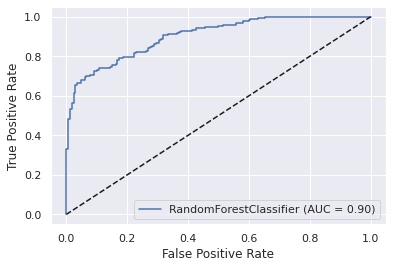

In [67]:
rf_disp = plot_roc_curve(clf, X_train, y_train)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       167
           1       0.82      0.85      0.84       253

    accuracy                           0.80       420
   macro avg       0.79      0.79      0.79       420
weighted avg       0.80      0.80      0.80       420

Accuracy =  0.8

Confusion Matrix


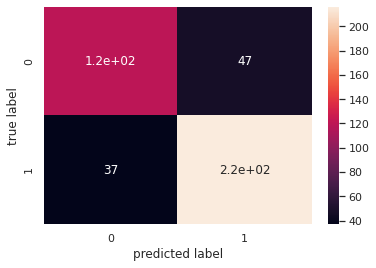

In [68]:
print(classification_report(y_train, y_pred_0))

print("Accuracy = ", accuracy_score(y_train, y_pred_0))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_train, y_pred_0)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

#### Test metrics -RF

In [69]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

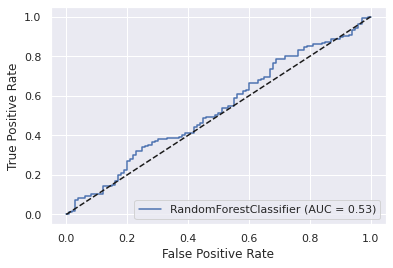

In [70]:
rf_disp = plot_roc_curve(clf, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.show();

              precision    recall  f1-score   support

           0       0.43      0.32      0.37       100
           1       0.67      0.76      0.71       181

    accuracy                           0.60       281
   macro avg       0.55      0.54      0.54       281
weighted avg       0.58      0.60      0.59       281

Accuracy =  0.604982206405694

Confusion Matrix


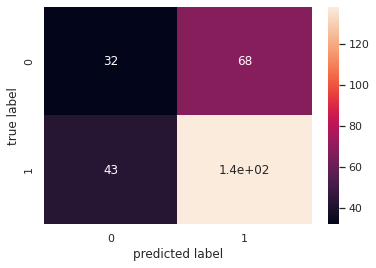

In [71]:
print(classification_report(y_test, y_pred))

print("Accuracy = ", accuracy_score(y_test, y_pred))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

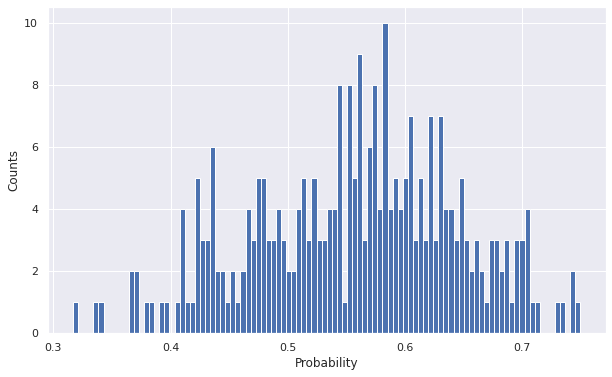

In [72]:
p = pd.Series(y_pred_prob)
f=plt.figure(figsize=(10,6))
a = f.gca()
a.hist(p,bins=100)
plt.xlabel('Probability')
plt.ylabel('Counts')
plt.show()

In [73]:
p_rf = y_pred_prob # from RF (secondary model)

In [74]:
new_data = y_test.copy()
new_data['bin_pred_rf'] = y_pred
new_data['p'] = p_rf
new_data

,bin,bin_pred_rf,p
date_time,,,
2016-05-10 12:42:48,1,0,0.468091
2016-05-13 14:23:40,1,1,0.644741
2016-05-17 15:15:09,1,1,0.622689
2016-05-19 11:00:43,1,1,0.611006
2016-05-24 10:50:23,0,1,0.537647
...,...,...,...
2019-05-23 10:45:52,0,1,0.592169
2019-05-28 15:00:18,0,1,0.651776
2019-05-31 10:32:58,1,1,0.594527


In [75]:
new_events = events.loc[new_data.index]
bs_df = pd.concat([new_events, new_data],axis=1)

In [76]:
bs_df.head()

,t1,trgt,side,pt,sl,bin,bin_pred_rf,p
date_time,,,,,,,,
2016-05-10 12:42:48,2016-05-13 14:23:40,0.011863,-1.0,1,2,1,0,0.468091
2016-05-13 14:23:40,2016-05-24 10:50:23,0.011747,1.0,1,2,1,1,0.644741
2016-05-17 15:15:09,2016-05-24 10:50:23,0.011679,1.0,1,2,1,1,0.622689
2016-05-19 11:00:43,2016-05-20 12:00:26,0.011574,1.0,1,2,1,1,0.611006
2016-05-24 10:50:23,2016-06-07 10:42:29,0.011532,-1.0,1,2,0,1,0.537647


In [77]:
m_prob_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2, num_threads=3, pred=bs_df.side)
m_prob_rf

date_time
2016-05-10 12:42:48    0.050989
2016-05-13 14:23:40    0.237677
2016-05-17 15:15:09    0.199821
2016-05-19 11:00:43    0.180117
2016-05-24 10:50:23   -0.060190
                         ...   
2019-05-23 10:45:52    0.148773
2019-05-28 15:00:18    0.249959
2019-05-31 10:32:58    0.152670
2019-06-04 09:55:18    0.041519
2019-06-17 09:38:56    0.180398
Name: signal, Length: 281, dtype: float64

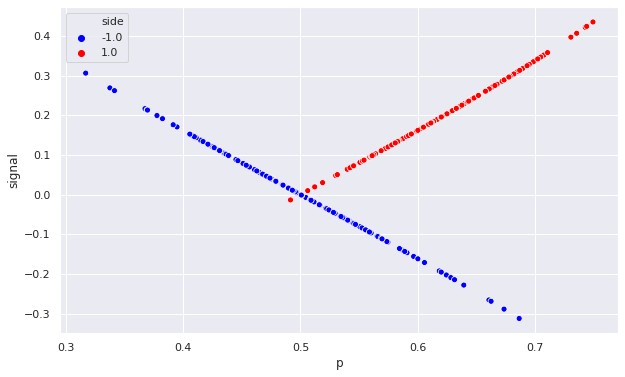

In [78]:
plt.figure(figsize=(10,6))
sns.scatterplot(x= bs_df.p, hue=bs_df.side, palette=['blue','red'],y=m_prob_rf)

Average Bet Sizing

In [79]:
m_prob_avg_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2, num_threads=3, average_active=True, pred=bs_df.side)
m_prob_avg_rf = m_prob_avg_rf.loc[bs_df.index]

2020-07-25 07:16:08.297916 100.0% mp_avg_active_signals done after 0.01 minutes. Remaining 0.0 minutes.


Discrete Average Bet Sizing

In [80]:
m_prob_discrete_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2,pred=bs_df.side, num_threads=3, average_active=True, step_size=0.05)
m_prob_discrete_rf = m_prob_discrete_rf.loc[bs_df.index]
m_prob_discrete_rf

2020-07-25 07:16:29.617037 100.0% mp_avg_active_signals done after 0.01 minutes. Remaining 0.0 minutes.


date_time
2016-05-10 12:42:48    0.05
2016-05-13 14:23:40    0.25
2016-05-17 15:15:09    0.20
2016-05-19 11:00:43    0.20
2016-05-24 10:50:23   -0.05
                       ... 
2019-05-23 10:45:52    0.15
2019-05-28 15:00:18    0.20
2019-05-31 10:32:58    0.20
2019-06-04 09:55:18    0.05
2019-06-17 09:38:56    0.20
Length: 281, dtype: float64

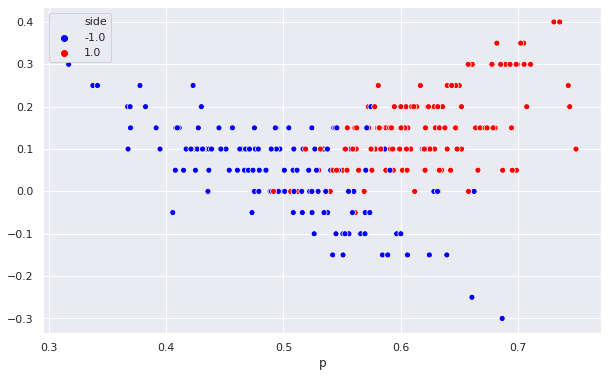

In [81]:
plt.figure(figsize=(10,6))
sns.scatterplot(x= bs_df.p, hue=bs_df.side, palette=['blue','red'],y=m_prob_discrete_rf)

### 3rd. Kelly Criterion

In [135]:
win_prob = np.mean(bs_df.p)
kelly = 2*win_prob-1
kelly

0.11360466546269277

### 4th. Budget Approach

In [85]:
m_budget = bs.bet_sizing.bet_size_budget(bs_df.t1, bs_df.side)
m_budget

,t1,side,active_long,active_short,bet_size
date_time,,,,,
2016-05-10 12:42:48,2016-05-13 14:23:40,-1.0,0,1,-0.142857
2016-05-13 14:23:40,2016-05-24 10:50:23,1.0,1,0,0.200000
2016-05-17 15:15:09,2016-05-24 10:50:23,1.0,2,0,0.400000
2016-05-19 11:00:43,2016-05-20 12:00:26,1.0,3,0,0.600000
2016-05-24 10:50:23,2016-06-07 10:42:29,-1.0,0,1,-0.142857
...,...,...,...,...,...
2019-05-23 10:45:52,2019-05-31 10:32:58,1.0,1,0,0.200000
2019-05-28 15:00:18,2019-05-31 15:36:00,1.0,2,0,0.400000
2019-05-31 10:32:58,2019-06-04 09:55:18,1.0,2,0,0.400000


overall

In [98]:
bet_sizes_others = pd.DataFrame({'mreserve':m_reserve[0].bet_size,'mbudget':m_budget.bet_size})
bet_sizes_rf = pd.DataFrame({'m_rf':m_prob_rf,'m_avg_rf':m_prob_avg_rf,'m_dis_rf':m_prob_discrete_rf})
bet_sizes = pd.concat([bet_sizes_rf, bet_sizes_others], axis=1).dropna()
bet_sizes['side'] = bs_df.side.loc[bet_sizes.index]

In [138]:
bet_sizes['kelly'] = np.ones(len(bet_sizes))*kelly
bet_sizes

,m_rf,m_avg_rf,m_dis_rf,mreserve,mbudget,side,kelly
2016-05-10 12:42:48,0.050989,0.050989,0.05,0.436041,-0.142857,-1.0,0.113605
2016-05-13 14:23:40,0.237677,0.237677,0.25,0.916645,0.200000,1.0,0.113605
2016-05-17 15:15:09,0.199821,0.218749,0.20,0.979670,0.400000,1.0,0.113605
2016-05-19 11:00:43,0.180117,0.205872,0.20,0.979670,0.600000,1.0,0.113605
2016-05-24 10:50:23,-0.060190,-0.060190,-0.05,0.000000,-0.142857,-1.0,0.113605
...,...,...,...,...,...,...,...
2019-05-23 10:45:52,0.148773,0.148773,0.15,0.436041,0.200000,1.0,0.113605
2019-05-28 15:00:18,0.249959,0.199366,0.20,0.750074,0.400000,1.0,0.113605
2019-05-31 10:32:58,0.152670,0.201314,0.20,0.750074,0.400000,1.0,0.113605
2019-06-04 09:55:18,0.041519,0.041519,0.05,-0.363556,-0.142857,-1.0,0.113605


Text(0.5, 1.0, 'Bet Size Distribution')

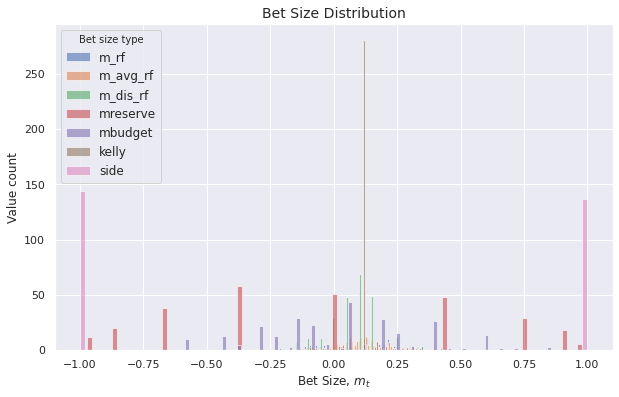

In [139]:
fig, ax = plt.subplots(figsize=(10,6))
for c in ['m_rf','m_avg_rf','m_dis_rf','mreserve','mbudget','kelly','side']:
    ax.hist(bet_sizes[c],  label=c, alpha=0.6, bins=100)
ax.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_xlabel("Bet Size, $m_t$", fontsize=12)
ax.set_ylabel("Value count", fontsize=12)
ax.set_title("Bet Size Distribution", fontsize=14)

# Backtest

2009 - 2016 train

2016- 2019 test

### Returns

In [140]:
data_size = bet_sizes.copy()
data_size['Close'] = close.loc[bet_sizes.index] # 가격
data_size['ret'] = bin.ret.loc[bet_sizes.index] # 진입부터 t1에 닿았을 때 수익률 (long 했을 때)

bet_ret = pd.DataFrame()
bet_ret['ProbRF'] = data_size.m_rf * data_size.ret
bet_ret['ProbAvgRF'] = data_size.m_avg_rf * data_size.ret
bet_ret['ProbDiscreteRF'] = data_size.m_dis_rf * data_size.ret
bet_ret['NoSize'] = data_size.side * data_size.ret
bet_ret['Reserve'] = data_size.mreserve * data_size.ret
bet_ret['Budget'] = data_size.mbudget * data_size.ret
bet_ret['Kelly'] = data_size.kelly * data_size.ret

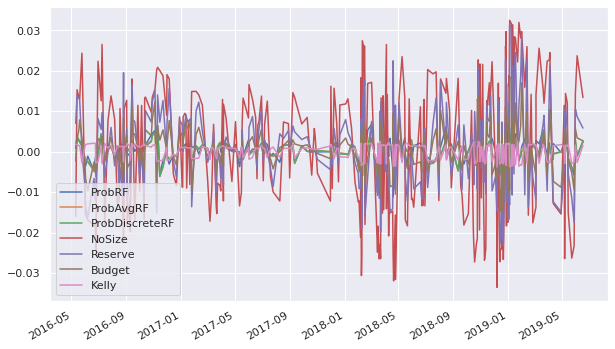

In [141]:
bet_ret.plot(figsize=(10,6))

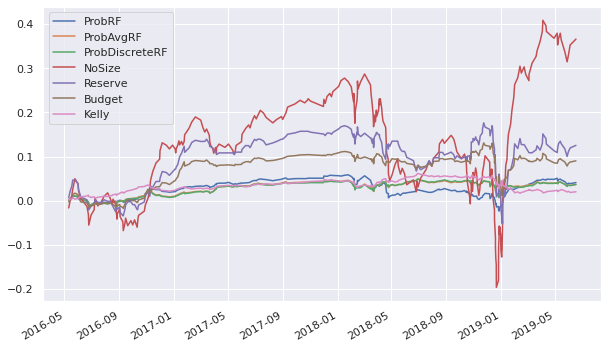

In [142]:
bet_ret.cumsum().plot(figsize=(10,6))

Bet sizing 이 무엇인가? Position? 

Kelly criterion 마냥 내 자산의 몇프로를 베팅하냐인가?

베팅되어 있는 내 wealth의 퍼센트를 말하는가?

전자라면 위의 수익률 측정이 맞다.

후자의 경우 다시 해보겠다.

In [144]:
#2nd version

bet_sizes_2 = bet_sizes.iloc[:,0:6].diff()

data_size = bet_sizes_2.copy()
data_size['Close'] = close.loc[bet_sizes_2.index] # 가격
data_size['ret'] = bin.ret.loc[bet_sizes_2.index] # 진입부터 t1에 닿았을 때 수익률 (long 했을 때)

bet_ret_2 = pd.DataFrame()
bet_ret_2['ProbRF'] = data_size.m_rf * data_size.ret
bet_ret_2['ProbAvgRF'] = data_size.m_avg_rf * data_size.ret
bet_ret_2['ProbDiscreteRF'] = data_size.m_dis_rf * data_size.ret
bet_ret_2['NoSize'] = data_size.side * data_size.ret
bet_ret_2['Reserve'] = data_size.mreserve * data_size.ret
bet_ret_2['Budget'] = data_size.mbudget * data_size.ret
#bet_ret_2['Kelly'] = data_size.kelly * data_size.ret

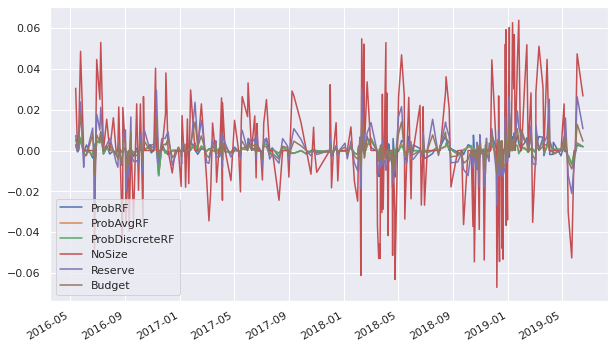

In [145]:
bet_ret_2.plot(figsize=(10,6))

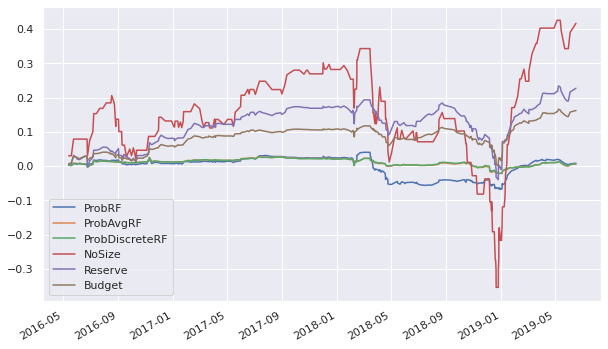

In [146]:
bet_ret_2.cumsum().plot(figsize=(10,6))

### Sharpe Ratio

In [132]:
def sr(df):
    out = pd.DataFrame(index=['Ann Sharpe Ratio'])
    for c in df.columns:
        out[c] = (df[c].mean()/df[c].std()*(252**.5))
    return out

In [148]:
sr(bet_ret)

,ProbRF,ProbAvgRF,ProbDiscreteRF,NoSize,Reserve,Budget,Kelly
Ann Sharpe Ratio,0.773283,0.839265,0.849433,1.201384,0.688124,0.954245,0.591416


bet size를 첫번째처럼 생각한다면 sizing 안하고 전재산 매수, 전재산 매도 하는게 유리함.

In [134]:
sr(bet_ret_2)

,ProbRF,ProbAvgRF,ProbDiscreteRF,NoSize,Reserve,Budget
Ann Sharpe Ratio,0.12604,0.160097,0.176289,0.949557,1.447598,1.885682


bet size를 두 번째처럼 생각한다면, Budget Approach> Cash Reserve Approach 순으로 괜찮음.

probability 방법이 performance가 안 좋은 이유는 RF의 성능이 좋기 때문.

# REFERENCE

Marcos Lopez de Prado. Advances in Financial Machine Learning. Wiley, 2018

https://github.com/hudson-and-thames/research

Marcos Lopez de Prado and Matthew D. Foreman. “A mixture of Gaussians approach to mathematical portfolio oversight: the EF3M algorithm”. In: Quantitative Finance14.5 (2014), pp. 913–930.

Yakup Kara
, Melek Acar Boyacioglu 
, Ömer Kaan Baykan. "Predicting direction of stock price index movement using artificial neural
networks and support vector machines: The sample of the Istanbul Stock Exchange"


https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities

Andersen, T. and O. Bondarenko (2013): “VPIN and the Flash Crash.” Journal of Financial Markets,
Vol. 17, pp.1-46.

s/o to mlfinlab, ta, pyfolio